# Autoencoder
### Load Data and Augment

In [2]:
ComputeLB = False

import os, gc, zipfile
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

if ComputeLB: PATH = 'simdata/image/'
else: PATH = 'simdata/image/'
IMAGES = os.listdir(PATH)
print('There are',len(IMAGES),'images. Here are 5 example filesnames:')
print(IMAGES[:5])

There are 1000 images. Here are 5 example filesnames:
['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '101.jpg']


### Build Autoencoder

In [3]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [4]:
BATCH_SIZE = 100; EPOCHS = 50
train_datagen = ImageDataGenerator(rescale=1./255)
train_batches = train_datagen.flow_from_directory('simdata/',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)

Found 1000 images belonging to 1 classes.


In [5]:
#ENCODER
input_img = Input(shape=(64, 64, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# LATENT SPACE
latentSize = (8,8,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

### Train Autoencoder

In [6]:
history = autoencoder.fit_generator(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
        epochs = EPOCHS, verbose=2)

C:\Users\zmz\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
10/10 - 42s - loss: 0.6639
Epoch 2/50
10/10 - 42s - loss: 0.6156
Epoch 3/50
10/10 - 39s - loss: 0.5963
Epoch 4/50
10/10 - 43s - loss: 0.5801
Epoch 5/50
10/10 - 42s - loss: 0.5599
Epoch 6/50
10/10 - 38s - loss: 0.5517
Epoch 7/50
10/10 - 40s - loss: 0.5501
Epoch 8/50
10/10 - 36s - loss: 0.5449
Epoch 9/50
10/10 - 34s - loss: 0.5410
Epoch 10/50
10/10 - 38s - loss: 0.5431
Epoch 11/50
10/10 - 40s - loss: 0.5389
Epoch 12/50
10/10 - 34s - loss: 0.5334
Epoch 13/50
10/10 - 34s - loss: 0.5308
Epoch 14/50
10/10 - 36s - loss: 0.5288
Epoch 15/50
10/10 - 38s - loss: 0.5314
Epoch 16/50
10/10 - 34s - loss: 0.5279
Epoch 17/50
10/10 - 36s - loss: 0.5264
Epoch 18/50
10/10 - 36s - loss: 0.5312
Epoch 19/50
10/10 - 37s - loss: 0.5354
Epoch 20/50
10/10 - 36s - loss: 0.5286
Epoch 21/50
10/10 - 38s - loss: 0.5256
Epoch 22/50
10/10 - 36s - loss: 0.5241
Epoch 23/50
10/10 - 36s - loss: 0.5234
Epoch 24/50
10/10 - 36s - loss: 0.5232
Epoch 25/50
10/10 - 34s - loss: 0.5221
Epoch 26/50
10/10 - 34s - loss: 0.

### View Reconstruction

Our encoder works by mapping images from 12288 dimensional space (64 x 64 x 3) into 2048 dimensional space (latent image). This is a 6x compression rate. Our decoder works by mapping our latent image back into 12288 dimensional space. Below are examples.

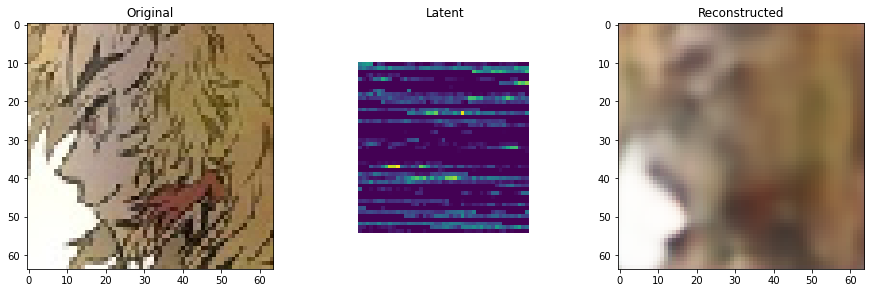

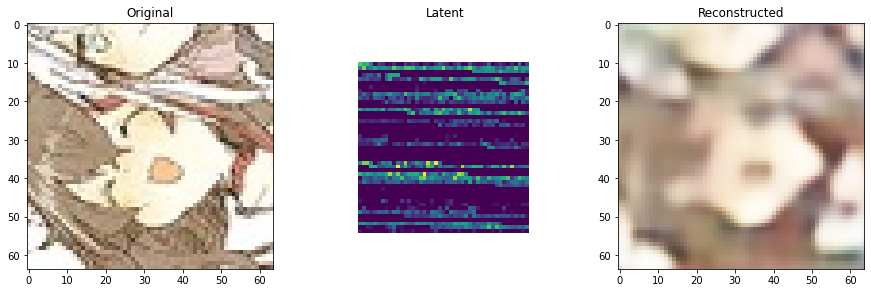

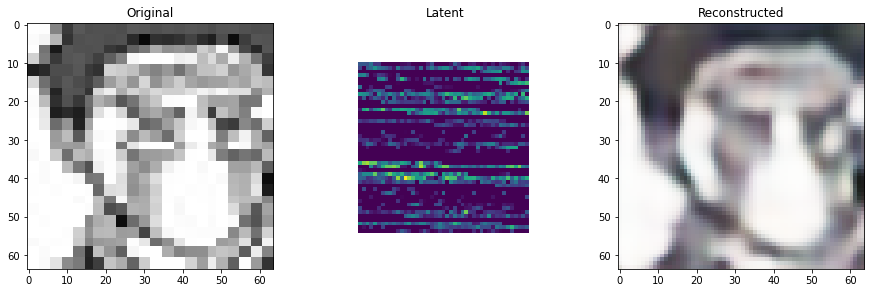

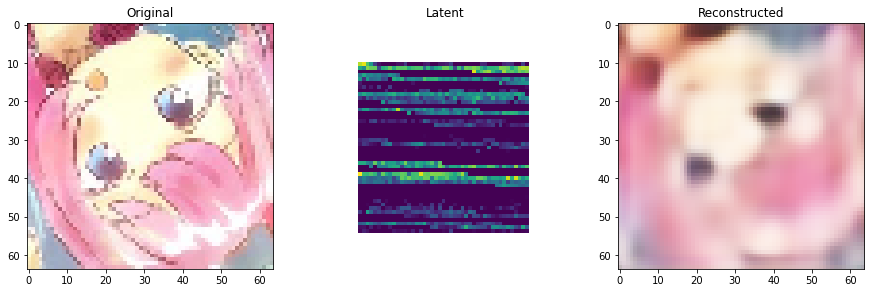

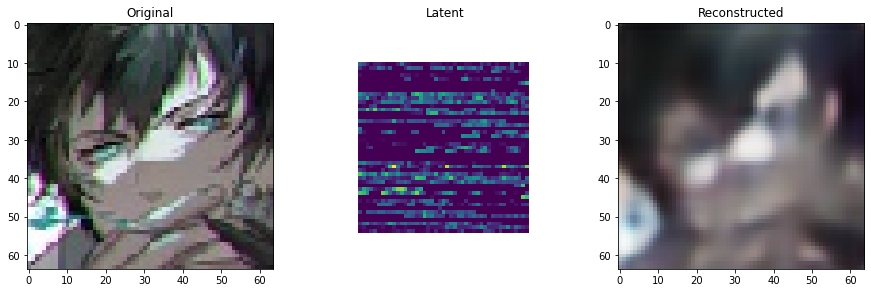

In [7]:
images = next(iter(train_batches))[0]
for i in range(5):

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    plt.title('Original')
    plt.imshow(img)

    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    img = Image.fromarray( latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L') 
    plt.subplot(1,3,2)
    plt.title('Latent')
    plt.xlim((-10,55))
    plt.ylim((-10,55))
    plt.axis('off')
    plt.imshow(img)

    # RECONSTRUCTED IMAGE
    decoded_imgs = decoder.predict(latent_img[0].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title('Reconstructed')
    plt.imshow(img)
    
    plt.show()

### Latent Space and Generation

We choose the size of latent space. In our autoencoder, we chose for latent space to be 2048 dimensional (6x compression). Below I have plotted 256 of the images in latent space as blue dots and drew their ellipsoid.

If we would like to generate a new image, we can chose a new random point (different from existing training image dots) inside this ellipsoid and then decode it. For example, we could choose the 64 red points below and then convert them into new generated images.

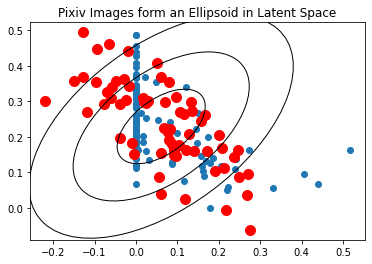

In [21]:
from matplotlib.patches import Ellipse

# PROJECT LATENT INTO 2D, AVOID DEAD RELU
latent_img = encoder.predict(images)
latent_img2 = latent_img.reshape((-1,latentSize[0]*latentSize[1]*latentSize[2]))
d = 0; s = 0
while s<0.1:
    x = latent_img2[:,d]
    s = np.std(x); d += 1
s = 0
while s<0.1:
    y = latent_img2[:,d]
    s = np.std(y); d += 1

# CALCULATE ELLIPSOID FROM 256 IMAGES
cov = np.cov(x, y)
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)
for j in [1,2,3]:
    ell = Ellipse(xy=(np.mean(x), np.mean(y)), width=lambda_[0]*j*2, 
            height=lambda_[1]*j*2, angle=np.rad2deg(np.arccos(v[0, 0])))
    ell.set_facecolor('None')
    ell.set_edgecolor('black')
    plt.gca().add_artist(ell)
    
# PLOT 256 IMAGES AS DOTS IN LATENT SPACE
plt.scatter(x,y)
d = np.random.multivariate_normal([np.mean(x),np.mean(y)],cov,64)
plt.scatter(d[:,0],d[:,1],color='red',s=100)
plt.title('Pixiv Images form an Ellipsoid in Latent Space')
plt.show()

In [22]:
    
encoded_imgs = encoder.predict(images)
sz = latentSize[0] * latentSize[1] * latentSize[2]
encoded_imgs = encoded_imgs.reshape((-1,sz))
mm = np.mean(encoded_imgs,axis=0)
ss = np.cov(encoded_imgs,rowvar=False)
# GENERATE 64 RANDOM IMAGES
generated = np.random.multivariate_normal(mm,ss,64)
generated = generated.reshape((-1,latentSize[0],latentSize[1],latentSize[2]))



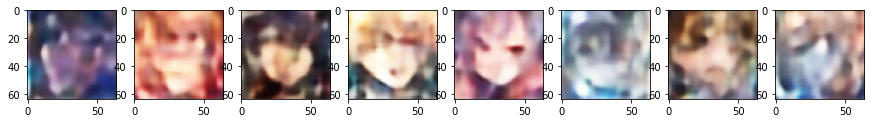

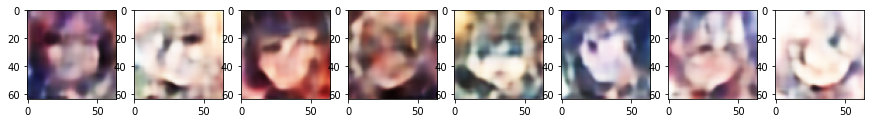

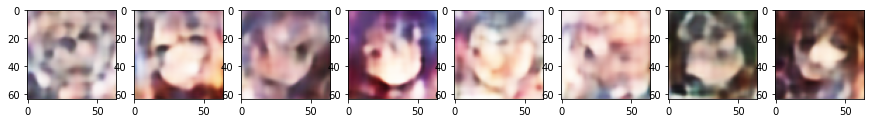

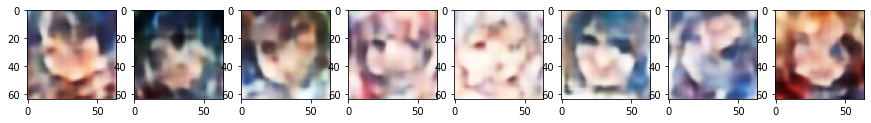

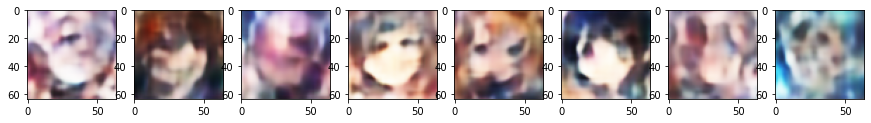

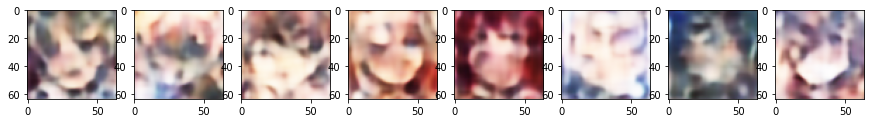

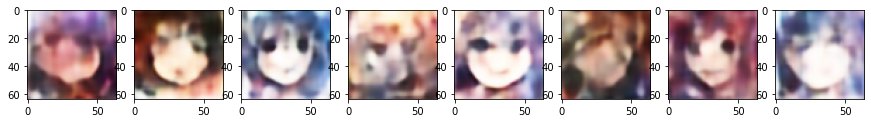

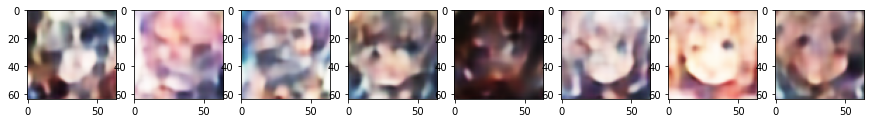

In [23]:
# PLOT 64 RANDOM IMAGES
for k in range(8):
    plt.figure(figsize=(15,5))
    plt.subplot(1,8,1)
    decoded_imgs = decoder.predict(generated[k*8].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,2)
    decoded_imgs = decoder.predict(generated[k*8+1].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,3)
    decoded_imgs = decoder.predict(generated[k*8+2].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,4)
    decoded_imgs = decoder.predict(generated[k*8+3].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,5)
    decoded_imgs = decoder.predict(generated[k*8+4].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,6)
    decoded_imgs = decoder.predict(generated[k*8+5].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,7)
    decoded_imgs = decoder.predict(generated[k*8+6].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,8)
    decoded_imgs = decoder.predict(generated[k*8+7].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.show()


### Generating Better Images

The generated images above are not very recognizable. Instead of choosing completely random points in latent space, we can choose points near existing training images. 

In [24]:
# DISTANCE TO MOVE AWAY FROM EXISTING TRAIN IMAGES
beta = 0.35
# GENERATE 9 RANDOM DOG IMAGES
generated = np.random.multivariate_normal(mm,ss,64)
generated = beta*generated + (1-beta)*encoded_imgs[:64]

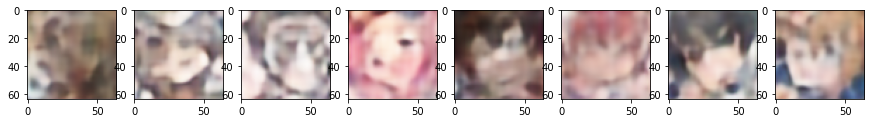

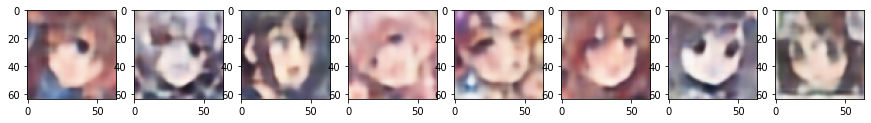

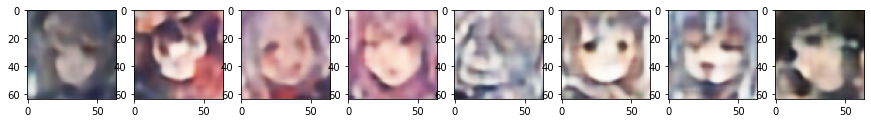

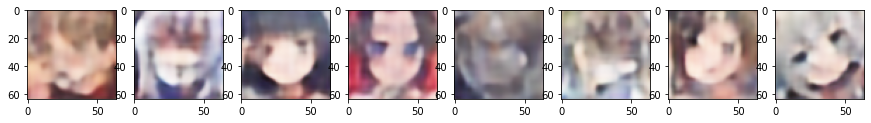

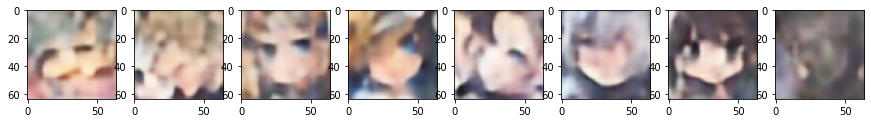

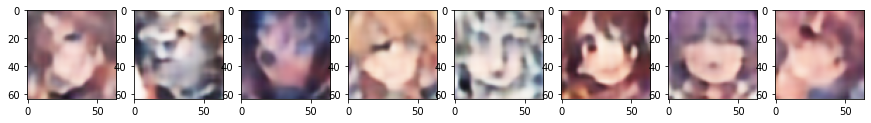

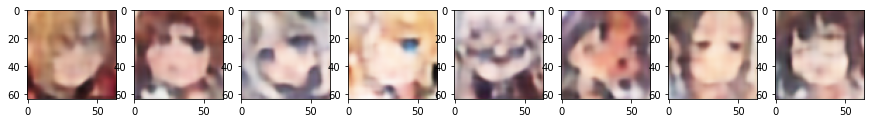

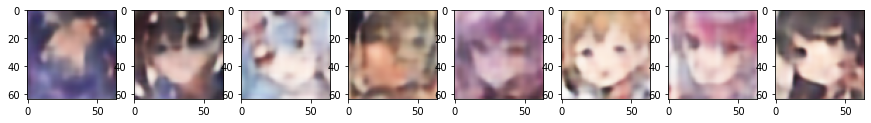

In [25]:
for k in range(8):
    plt.figure(figsize=(15,5))
    plt.subplot(1,8,1)
    decoded_imgs = decoder.predict(generated[k*8].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,2)
    decoded_imgs = decoder.predict(generated[k*8+1].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,3)
    decoded_imgs = decoder.predict(generated[k*8+2].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,4)
    decoded_imgs = decoder.predict(generated[k*8+3].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,5)
    decoded_imgs = decoder.predict(generated[k*8+4].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,6)
    decoded_imgs = decoder.predict(generated[k*8+5].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,7)
    decoded_imgs = decoder.predict(generated[k*8+6].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,8,8)
    decoded_imgs = decoder.predict(generated[k*8+7].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img) 
    
    plt.show()

### Conclusion

64 fake images are created by AE architecture. From the result, it can generate some animated faces with not so obvious outlines and hard to recognize the generated animated faces, just like making the compression on original images with less quality. Compariing to GAN and VAE, it got worst generation results.Because AE doesn't has a layer of data means and standard deviations, which are used to genrate the core representations value like VAE, so it is not very fit to generate a high-quality images.

Because of the memory and running speed limitation of my laptop, this model doesn't train the entire dataset as much as GAN and VAE, so this should also be a reason for it's unideal results.

After adjusting the size of the latent space and changing the network architecture, current combination can reach its best to balence between compression and quility. 

Copyright <2021>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so,subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.